## Load packages 
We load the packages used for the analysis

In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import glob 
from keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Flatten , Conv2D, MaxPooling2D, Dropout, InputLayer
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import os 
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
for dirname, _, filenames in os.walk('/kaggle/input'):
     print(dirname, "contains", len(filenames), "files.")
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate contains 1 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/EGL contains 270 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test/ML contains 270 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train contains 0 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/EGL contains 1080 files.
/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train/ML contains 1080 files.


In [2]:
tf.__version__

'2.4.1'

In [3]:
# Check if tensorflow can find GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
print(gpus)

Name: /physical_device:GPU:0   Type: GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13960851936296883786,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15685569792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17715876403038843378
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [6]:
tf.test.is_gpu_available()

True

In [7]:
!nvidia-smi

Tue Mar  2 11:26:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    367MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load data


In [8]:
train_data = '/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/train'
test_data = '/kaggle/input/p7eglmltilesshiftrotate/P7-EGL-ML-tiles-shift-rotate/test'
batch_size = 128
img_height = 300
img_width = 300

## Split train data
spliting train data into **train** and **validation** with 80:30 ratio

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
                             #rescale=1./255, 
                             #rotation_range = 40,
                             #width_shift_range = 0.2,
                             #height_shift_range = 0.2,
                             #horizontal_flip=True,
                             #vertical_flip=True,
                             validation_split=0.3,
                             #fill_mode = 'nearest'
                            )

train_generator = datagen.flow_from_directory(
    train_data,
    shuffle=True,
    target_size = (300,300),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode='grayscale',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    train_data,
     shuffle=True,
    target_size = (300,300),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode='grayscale',
    subset = 'validation'
)

Found 1512 images belonging to 2 classes.
Found 648 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
                             #rescale=1./255, 
                             #rotation_range = 40,
                             #width_shift_range = 0.2,
                             #height_shift_range = 0.2,
                             #horizontal_flip=True,
                             #vertical_flip=True,
                             #validation_split=0.3,
                             #fill_mode = 'nearest'
                                 )

test_generator = datagen.flow_from_directory(
    test_data,
    #shuffle=True,
    target_size = (300,300),
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode='grayscale'
)

Found 540 images belonging to 2 classes.


In [11]:
augmented_images = [train_generator[0][0][0] for i in range(6)]
#plotImages(augmented_images)
#plt.imshow(augmented_images[0])


## Model Creation 
### Define the model 

In [12]:
#Define model
model=tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
        ###keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(1024, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#Compile the model
model.compile(
              optimizer=opt, 
              #optimizer='adam', 
              loss='binary_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['acc']
              #metrics=['accuracy', 'f1score', 'precision', 'recall']
             )

#Print model summary
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 256)       2

## Train cnn model 

In [13]:
#Fitting the model
num_epochs = 50
history = model.fit(train_generator,
                    #steps_per_epoch=100,#(image_count-val_size) // batch_size,
                    epochs=num_epochs,
                    #validation_steps=100,#val_size // batch_size,
                    validation_data=validation_generator,
                    verbose=1
                   )

Epoch 1/50
12/12 [==============================] - 21s 1s/step - loss: 0.5067 - acc: 0.7422 - val_loss: 0.8091 - val_acc: 0.5000
Epoch 2/50
12/12 [==============================] - 9s 797ms/step - loss: 0.1089 - acc: 0.9669 - val_loss: 2.6555 - val_acc: 0.5000
Epoch 3/50
12/12 [==============================] - 10s 842ms/step - loss: 0.0679 - acc: 0.9844 - val_loss: 3.2254 - val_acc: 0.5000
Epoch 4/50
12/12 [==============================] - 10s 825ms/step - loss: 0.0528 - acc: 0.9870 - val_loss: 1.2656 - val_acc: 0.5000
Epoch 5/50
12/12 [==============================] - 9s 801ms/step - loss: 0.0348 - acc: 0.9923 - val_loss: 2.6940 - val_acc: 0.5000
Epoch 6/50
12/12 [==============================] - 9s 787ms/step - loss: 0.0258 - acc: 0.9927 - val_loss: 1.9072 - val_acc: 0.5000
Epoch 7/50
12/12 [==============================] - 10s 836ms/step - loss: 0.0200 - acc: 0.9922 - val_loss: 0.8245 - val_acc: 0.5772
Epoch 8/50
12/12 [==============================] - 9s 801ms/step - loss: 0

## Visualizing results of the training 

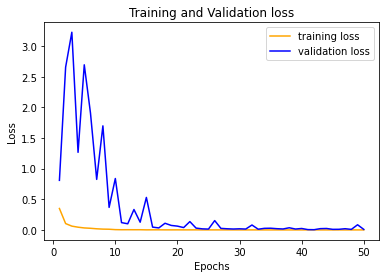

In [14]:
num_epochs = num_epochs
loss_train = history.history['loss'][:num_epochs]
loss_val = history.history['val_loss'][:num_epochs]
epochs = range(1,num_epochs+1)
plt.plot(epochs,loss_train, 'orange', label='training loss')
plt.plot(epochs, loss_val, 'b', label= 'validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

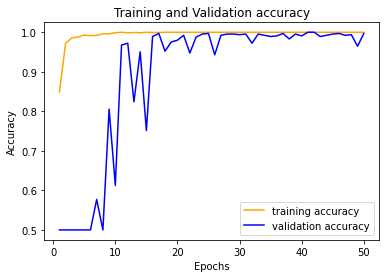

In [17]:
num_epochs = num_epochs
acc_train = history.history['acc'][:num_epochs]
acc_val = history.history['val_acc'][:num_epochs]
epochs = range(1,num_epochs+1)
plt.plot(epochs,acc_train, 'orange', label='training accuracy')
plt.plot(epochs, acc_val, 'b', label= 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()